In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras import layers

import gensim
# import gensim.downloader as api
# from gensim.models import Word2Vec

Using TensorFlow backend.


ERROR! Session/line number was not unique in database. History logging moved to new session 188


In [ ]:
# word_vectors = api.load("glove-twitter-200")
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(
    '/home/msinxi/gensim-data/glove-twitter-200/glove-twitter-200.gz')  

In [34]:
# import data
raw_data =  pd.read_csv('../raw-data/skills_test.csv')

In [19]:
raw_data.head()

,Text,label
0,I bought a car through a dealership and had so...,1
1,"April 7, 2006 Wells Fargo Bank announced they ...",1
2,Securities watchdog investigates Wells Fargo o...,1
3,I had a problem where for months my student lo...,1
4,If someone opens a bank account without your k...,1


In [20]:
# Check balance of the two classes
print(raw_data[raw_data['label'] == 0]['label'].count())
print(raw_data[raw_data['label'] == 1]['label'].count())

1914
1914


In [33]:
def clean_text(s):
    """
    Pre-process text data by removing stop words, puncuation and strange characters
    
    return string
    """
    lemma = WordNetLemmatizer()
    porter = PorterStemmer()
    symbols_re = re.compile('[^a-z #+_]')
    space_re = re.compile('[/(){}\[\]\|@,;]')
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.lower()
    s = symbols_re.sub('', s)
    s = space_re.sub(' ', s)
    s = ' '.join([l for l in s.split() if l not in stopwords.words('english')])
    normalized = " ".join(lemma.lemmatize(word) for word in s.split())
    stemmed = " ".join(porter.stem(word) for word in normalized.split())
    return stemmed

In [40]:
def plot_cm(cf, filename='cm.png'):
    """
    Plot the confusion matrix
    """
    plt.matshow(cf)
    plt.title('Confusion Matrix Plot')
    plt.colorbar()
    plt.xlabel('Precited')
    plt.ylabel('Actual')
    plt.savefig(filename)
    plt.show()

In [23]:
def tokenize_CountVectorizer(text_train, text_test, all_text):
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=None)
    vectorizer.fit(text_train)
    X_train = vectorizer.transform(text_train)
    X_test  = vectorizer.transform(text_test)
    text_vects = vectorizer.transform(all_text)
    return X_train, X_test, text_vects 

In [24]:
def tokenize_tfidf(text_train, text_test, all_text):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(text_train)
    X_train = vectorizer.transform(text_train)
    X_test  = vectorizer.transform(text_test)
    text_vects = vectorizer.transform(all_text)
    return X_train, X_test, text_vects 

In [25]:
def word_embedding(word_vectors,text_train, text_test, all_text):
    dimsize = 200
    # tokenize sentences
    X_train = text_train.apply(lambda x: nltk.word_tokenize(x))
    X_train = X_train.apply(lambda x: np.array([avg_word_vectors(word_vectors,w,200) for w in x]).mean(axis=0)[0])
    X_train = np.vstack((X_train))
    
    X_test = text_test.apply(lambda x: nltk.word_tokenize(x))
    X_test = X_test.apply(lambda x: np.array([avg_word_vectors(word_vectors,w,200) for w in x]).mean(axis=0)[0])
    X_test = np.vstack((X_test))
    
    text_vects = raw_data['Text'].apply(lambda x: nltk.word_tokenize(x))
    text_vects = text_vects.apply(lambda x: np.array([avg_word_vectors(word_vectors,w,200) for w in x]).mean(axis=0)[0])
    text_vects = np.vstack((text_vects))
    return  X_train, X_test, text_vectors

In [26]:
def avg_word_vectors(model,wordlist,size):
    """
    returns a vector of zero for text containing words where none of them
    met the min_count or were not seen in the training set
    Otherwise return an average of the embeddings vectors
    """
    sumvec = np.zeros(shape=(1,size))
    wordcnt = 0
    for w in wordlist:
        if w in model:
            sumvec += model[w]
            wordcnt +=1

        if wordcnt == 0:
            print(w)
            return sumvec
        else:
            return sumvec / wordcnt

In [27]:
def classifier(classifier_method, X_train, X_test, y_train, y_test, text_vects, filename='cm.png'):
# nb = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', MultinomialNB()),
#               ])

    classifier = classifier_method
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    cf = confusion_matrix(y_test, y_pred)
    scores = cross_val_score(classifier, text_vects, raw_data['label'], cv=10)
    print('Average score from cross-validation {}'.format(scores.mean()))
    plot_cm(cf, filename=filename)
    return

In [35]:
# logger.info('cleaning text, this may take 1-2 minutes...')
raw_data['Text'] = raw_data['Text'].apply(clean_text)

split the data into training set and test set using scikitlearn

In [36]:
x = raw_data['Text']
y = raw_data['label']
text_train, text_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [37]:
text_train

1713    rebuild path reward valu card meh top bank que...
145     bank said would refund credit million cover fe...
3307    howev le newsworthi photogen sibl suit crime w...
2459    vintag retro best banker america blame well fa...
1426    one target custom forc u loan builder hous elk...
512     model tell best result instal loan ok would ta...
2799    get ur ticket via ebay googldhlrn panic disco ...
421     imagin feel amaz million settlement well fargo...
3401    money transfer well fargo medic transcript edi...
2391    well fargo scam discrimin custom mani time sti...
401     utehcheez home loan well fargo anyway transfer...
3196    well fargo launch new websit design button don...
1294    fine penalti well fargo bank bad act custom ot...
3158    top regul written way vagu contradict lead sor...
2540    keepheatonbank wellsfargo board slam former ce...
1050    well return million million addit custom appea...
655     xxxxxxxx well fargo disregard releaseofleviedf...
3679    vehicl

In [50]:
X_train, X_test, text_vects = tokenize_CountVectorizer(text_train, text_test, raw_data['Text'])

In [44]:
X_train, X_test, text_vects = tokenize_tfidf(text_train, text_test, raw_data['Text'])

In [63]:
X_train, X_test, text_vects = word_embedding(word_vectors, text_train, text_test, raw_data['Text'])

NameError: name 'word_vectors' is not defined

accuracy 0.7397737162750218
              precision    recall  f1-score   support

           0       0.91      0.54      0.67       577
           1       0.67      0.94      0.78       572

    accuracy                           0.74      1149
   macro avg       0.79      0.74      0.73      1149
weighted avg       0.79      0.74      0.73      1149

Average score from cross-validation 0.7910026723385688


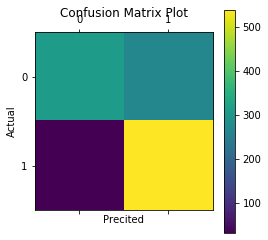

In [45]:
## Naive Bayes Classifier for Multinomial Models
classifier(MultinomialNB(), X_train, X_test, y_train, y_test, text_vects, filename='multinomial_tfidf.png')

accuracy 0.9033942558746736
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       577
           1       0.91      0.90      0.90       572

    accuracy                           0.90      1149
   macro avg       0.90      0.90      0.90      1149
weighted avg       0.90      0.90      0.90      1149

Average score from cross-validation 0.9004785667539268


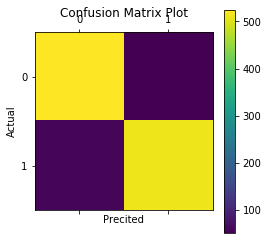

In [46]:
# Linear Support Vector Machine
classifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None), 
           X_train, X_test, y_train, y_test, text_vects, filename='svm_linear_tfidf.png')

accuracy 0.927763272410792
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       577
           1       0.92      0.93      0.93       572

    accuracy                           0.93      1149
   macro avg       0.93      0.93      0.93      1149
weighted avg       0.93      0.93      0.93      1149

Average score from cross-validation 0.9268733638743456


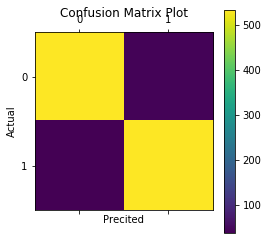

In [47]:
## Linear Support Vector Machine
classifier(LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=200),
           X_train, X_test, y_train, y_test, text_vects, filename='logistic_tfidf.png')

accuracy 0.9704090513489991
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       577
           1       0.99      0.95      0.97       572

    accuracy                           0.97      1149
   macro avg       0.97      0.97      0.97      1149
weighted avg       0.97      0.97      0.97      1149

Average score from cross-validation 0.9691876636125656


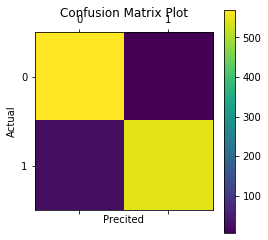

In [51]:
## Decision Tree
classifier(DecisionTreeClassifier(max_depth=10,random_state=0), 
           X_train, X_test, y_train, y_test, text_vects, filename='dtree_bow.png')

accuracy 0.906875543951262
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       577
           1       0.90      0.91      0.91       572

    accuracy                           0.91      1149
   macro avg       0.91      0.91      0.91      1149
weighted avg       0.91      0.91      0.91      1149

Average score from cross-validation 0.9127563263525307


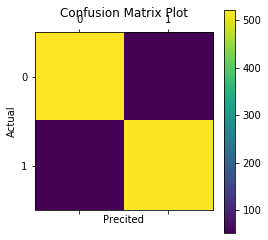

In [52]:
## Random Forrest Classifier
classifier( RandomForestClassifier(n_estimators=10, max_depth=None,random_state=0),
           X_train, X_test, y_train, y_test, text_vects, filename='randf_bow.png')

## Neural Networks in Keras with Tensorflow in the backend

In [51]:
num_feat = X_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=num_feat, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [52]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                130270    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 130,281
Trainable params: 130,281
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [60]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9996
Testing Accuracy:  0.8808


In [61]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

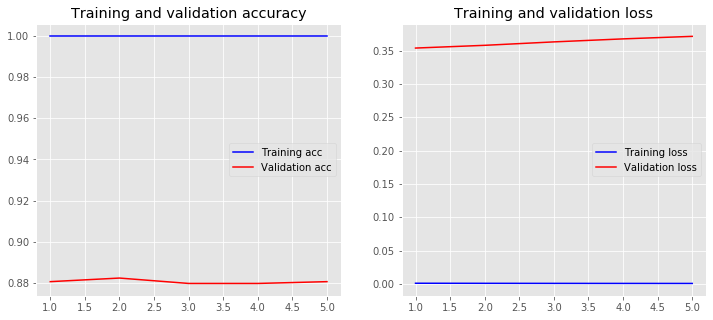

In [62]:
plot_history(history)